In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

In [19]:
##Reading in formatted dataset

kick_data = pd.read_csv('Formatted Kicker Stats.csv')

kick_data = kick_data.drop('Unnamed: 0', axis=1)

kick_data.sort_values(by='TEAM', ascending=True).head(20)

#Noticed an error in the data. Adjusting#
kick_data.loc[(kick_data['NAME'] == 'Graham Nicholson') & (kick_data['XPA'] == 37), 'XPA'] = 36

kick_data[kick_data['NAME'] == 'Alex McPherson']

# Display the modified DataFrame

##Nice and clean :D

,NAME,TEAM,XPM,XPA,1-19M,1-19A,20-29M,20-29A,30-39M,30-39A,40-49M,40-49A,50+M,50+A,FGM,FGA,LNG
72,Alex McPherson,AUB,39,39,0,0,3,3,6,6,3,3,1,1,13,13,53


Now to create the Value Added Formula

As a Reminder for a given yardage split:

Expected Points = Total Yardage FG% * Value of FG (3)

Actual Points = Individual Yardage Makes * Value of FG (3)

Kicker Yardage AV = Actual Points - Expected Points


Example: Total Average from 50+ is 50%, so expected PPK is 1.5

If a kicker goes 3/5 from 50+ you'd calculate Added Value by:

(3 x 3)  - (1.5 x 5)

(9 - 7.5)

1.5 Points Added Value

In [3]:
##First, we need average conversation %s across each split

##Going to start by making a Total row at the bottom of the table we can reference
cols_to_sum = ['XPM', 'XPA', 
                       '1-19M', '1-19A', 
                       '20-29M', '20-29A', 
                       '30-39M', '30-39A', 
                       '40-49M', '40-49A', 
                       '50+M', '50+A', 
                       'FGM', 'FGA']
##Using .loc method to create
for col in cols_to_sum:
    kick_data.loc['Total', col] = kick_data[col].sum()

kick_data.loc['Total']

NAME         NaN
TEAM         NaN
XPM       4820.0
XPA       4906.0
1-19M       14.0
1-19A       14.0
20-29M     573.0
20-29A     613.0
30-39M     647.0
30-39A     780.0
40-49M     490.0
40-49A     751.0
50+M       123.0
50+A       252.0
FGM       1846.0
FGA       2409.0
LNG          NaN
Name: Total, dtype: object

In [4]:
##Now, we reference the Total row to easily create Conversation Rates

conversion_rates = {}

conversion_rates['XP'] = round((kick_data.loc['Total', 'XPM'] / kick_data.loc['Total', 'XPA']) * 100,2)
conversion_rates['1-19'] = round((kick_data.loc['Total', '1-19M'] / kick_data.loc['Total', '1-19A']) * 100,2)
conversion_rates['20-29'] = round((kick_data.loc['Total', '20-29M'] / kick_data.loc['Total', '20-29A']) * 100,2)
conversion_rates['30-39'] = round((kick_data.loc['Total', '30-39M'] / kick_data.loc['Total', '30-39A']) * 100,2)
conversion_rates['40-49'] = round((kick_data.loc['Total', '40-49M'] / kick_data.loc['Total', '40-49A']) * 100,2)
conversion_rates['50+'] = round((kick_data.loc['Total', '50+M'] / kick_data.loc['Total', '50+A']) * 100,2)

In [5]:
##Creating series for basic conversaion graphing

conversion_x = []
conversion_y = ['XP', '1-19', '20-29', '30-39', '40-49', '50+']
for i in conversion_y:
    conversion_x.append(conversion_rates[i])

/var/folders/3_/s0jb41qj607g72j5zzcpvdgh0000gn/T/ipykernel_39912/2965429042.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversion_x, y=conversion_y, orient='h', palette='OrRd_r')


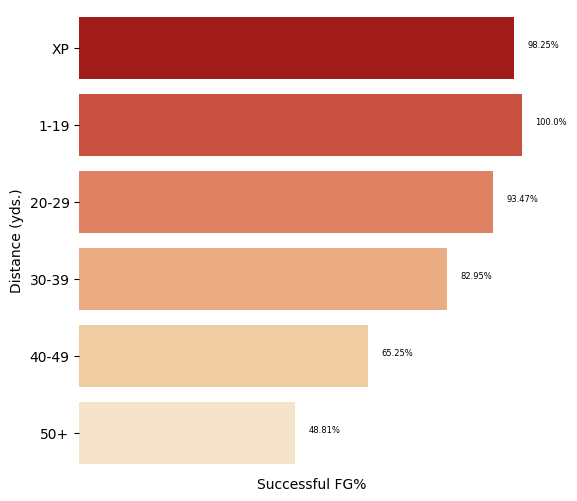

In [6]:
##This is lifted straight from my previous entires
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x=conversion_x, y=conversion_y, orient='h', palette='OrRd_r')
##Prettification :)
##This will be used for the SYB post, but it will be re-created for the Tableau Dash

sns.despine(left=True, bottom=True)
sns.set_context('notebook', font_scale=.5)
ax.set_xlabel('Successful FG%')
ax.set_ylabel('Distance (yds.)')
ax.set_xticks([]) ##Removes all x-axis ticks
for i,v in enumerate(conversion_x): ##creates a label off the end of the bar that shows a percentage
    ax.text(v + 3, i, str(v) + '%', color='black', fontweight='ultralight')


Now that we have conversion rates, we multiply by 3 (or by 1 for XP) to get Expected Values

In [7]:
##Because they are going against percentages, multiply by .03 and not .01

expected_values = {}
for i in conversion_rates:
    if i != 'XP':
        expected_values[i] = round(conversion_rates[i] * .03,3)
    else:
        expected_values[i] = round(conversion_rates[i] * .01,3)

expected_values

{'XP': 0.982,
 '1-19': 3.0,
 '20-29': 2.804,
 '30-39': 2.488,
 '40-49': 1.958,
 '50+': 1.464}

We now have everything we need to calculate each Kicker's Yardage Splits for Added Value

In [8]:
#Redefine list to iterate over
cols_to_calc = ['XP', '1-19', '20-29', '30-39', '40-49', '50+']

#Creating added value columns
for i in cols_to_calc:
    if i == 'XP':
        kick_data[i + '_AV'] = kick_data[i+'M'] - (expected_values[i]*kick_data[i+'A'])
    else:
        kick_data[i + '_AV'] = (kick_data[i+'M'] * 3) - (expected_values[i]*kick_data[i+'A'])

##THESE NUMBERS ARE VERIFIRED CORRECT

In [9]:
##Some light formatting to make it easier to read
pd.set_option("display.max_columns", None)

##Iterating to isolate AV columns to be summed
cols_to_sum = []

for i in kick_data.columns:
    if i[-3:] == '_AV':
        cols_to_sum.append(i)

##Totaling Added Value
kick_data['TOTAL_AV'] = kick_data[cols_to_sum].sum(axis=1)

##THESE NUMBERS ARE VERIFIED CORRECT

In [10]:
##Next, calculating Absolute Added Value for each yardage split to see which was most decisive
abs_value = {}
yardages = ['XP','1-19', '20-29', '30-39', '40-49', '50+']
for i in yardages:
    abs_value[i] = abs(kick_data[i+'_AV']).sum()

In [11]:
##Exporting a quick CSV so that I can get this into Tableau as well
kick_data.to_csv('Final Kicking Stats 2023.csv')

AND YOUR TOP TEN BY TOTAL ADDED VALUE ARE

🥁🥁🥁🥁🥁🥁🥁🥁🥁🥁🥁🥁🥁🥁🥁

In [12]:
sorted_data = kick_data.sort_values('TOTAL_AV', ascending=False)

sorted_data['Name'] = sorted_data['NAME']

sorted_data['Team'] = sorted_data['TEAM']

sorted_data['Added Value'] = sorted_data['TOTAL_AV']

sorted_data[['Name', 'Team', 'Added Value', 'FGA', 'FGM']].head(10)

,Name,Team,Added Value,FGA,FGM
1,Graham Nicholson,M-OH,14.900,28.0,27.0
3,Jose Pizano,UNLV,13.998,27.0,25.0
8,Joshua Karty,STAN,11.500,27.0,23.0
13,Will Reichard,ALA,11.154,23.0,20.0
5,Jonah Dalmas,BOIS,10.282,27.0,24.0
72,Alex McPherson,AUB,9.024,13.0,13.0
40,James Turner,MICH,8.862,18.0,16.0
0,Bert Auburn,TEX,8.272,34.0,28.0
24,Noah Burnette,UNC,8.136,19.0,18.0
11,Andres Borregales,MIA,7.770,25.0,21.0


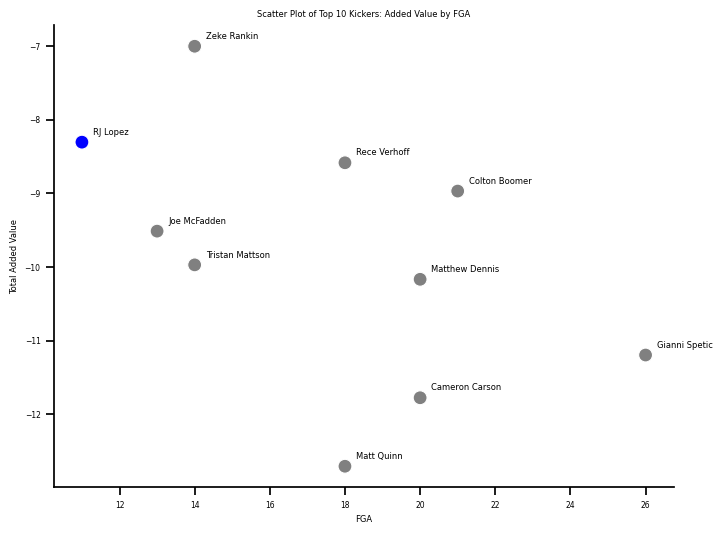

<Figure size 640x480 with 0 Axes>

In [13]:
##Scatterplot for the top 10 to show how Auburn guy had no attmpts and still got up there

top_ten = sorted_data[['Name', 'Team', 'Added Value', 'FGA', 'FGM']].tail(10).reset_index(drop=True)

##Colors to isolate Auburn PK
colors = ['blue' if name == 'RJ Lopez' else 'gray' for name in top_ten['Name']]

##Create Plot
plt.figure(figsize=(8, 6))
graph = sns.scatterplot(x='FGA', y='Added Value', data=top_ten, s=100, color=colors)

##Add labels
for i in range(len(top_ten)):
    graph.text(top_ten['FGA'][i] + .3, top_ten['Added Value'][i] + .1, top_ten['Name'][i],
                      fontsize=6, color='black')

##Add titles
plt.ylabel('Total Added Value')
plt.title('Scatter Plot of Top 10 Kickers: Added Value by FGA')
sns.despine()
plt.show()

##Saving
plt.savefig('Auburn Scatter.png')

AND ALSO THE BOTTOM TEN CAUSE WHY NOT

In [14]:
sorted_data = kick_data.sort_values('TOTAL_AV', ascending=True)

sorted_data.head(10)

calc = sorted_data[sorted_data['TOTAL_AV'] < 0]

calc['XP Misses'] = calc['XPA'] - calc['XPM']

calc['XP Misses'].mean()


/var/folders/3_/s0jb41qj607g72j5zzcpvdgh0000gn/T/ipykernel_39912/1921579946.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calc['XP Misses'] = calc['XPA'] - calc['XPM']


0.8153846153846154

Now, we make the BIG graph

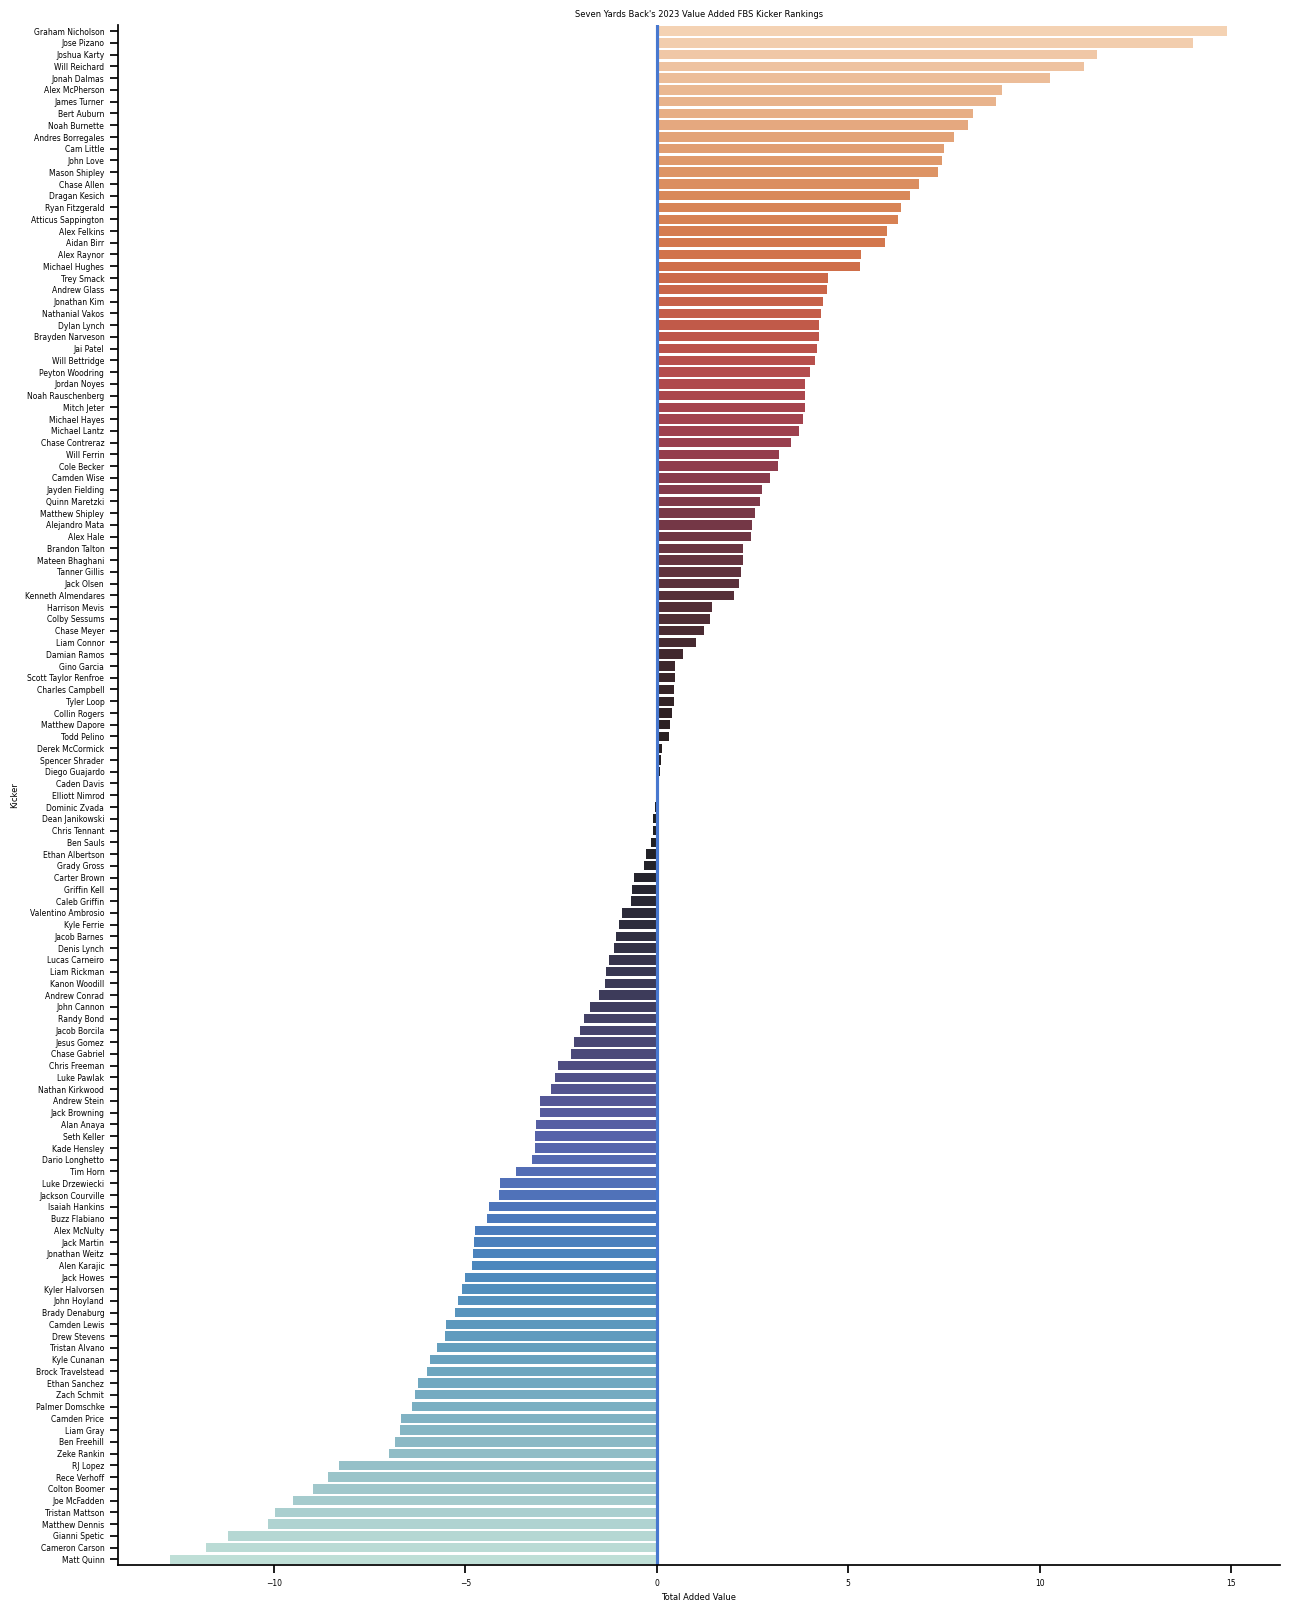

In [15]:
##Setting style, size. Going to replicate previous years for now
style.use('seaborn-v0_8-muted')
fig, ax = plt.subplots(figsize=(15,20))

##Creating the barplot
sorted_data = kick_data.sort_values('TOTAL_AV', ascending=False)
ax = sns.barplot(x='TOTAL_AV', y='NAME', data=sorted_data, orient='h', palette='icefire_r', hue='NAME', legend=False)
ax.set_title("Seven Yards Back's 2023 Value Added FBS Kicker Rankings")
ax.set_xlabel('Total Added Value')
ax.set_ylabel('Kicker')

##Prettification
sns.despine()
sns.set_context('talk', font_scale=.3) ##Gotta try to make the names readable

plt.axvline(0,0,1,ls='-') ##vertical line down the middle for niceness
font = {'size': 22}

plt.rc('font', **font)
plt.savefig('Updated Rankings.png')

Before I introduce the Normalized chart, I think it would be interesting to calculate the exact relationship between FGA and TAV

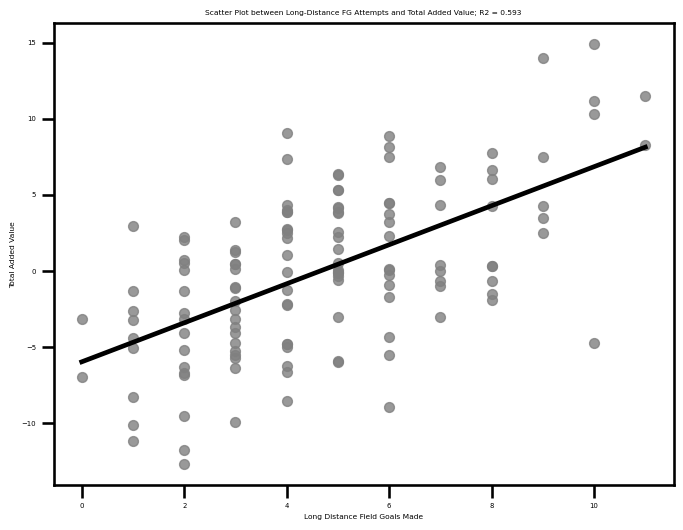

In [16]:
#Removing Total for scatter plot
kick_data['LDM'] = kick_data['40-49M'] + kick_data['50+M']
kick_data = kick_data.drop(kick_data.index[-1])

# Calculate the correlation coefficient (r value)
correlation = round(kick_data['LDM'].corr(kick_data['TOTAL_AV']),3)

plt.figure(figsize=(8, 6))
sns.regplot(x='LDM', y='TOTAL_AV', data=kick_data, scatter_kws={'s': 50, 'alpha': 0.8, 'color': 'gray'},ci=None, line_kws={'color': 'black'})
plt.title(f'Scatter Plot between Long-Distance FG Attempts and Total Added Value; R2 = {correlation}')
plt.xlabel('Long Distance Field Goals Made')
plt.ylabel('Total Added Value')
plt.show()

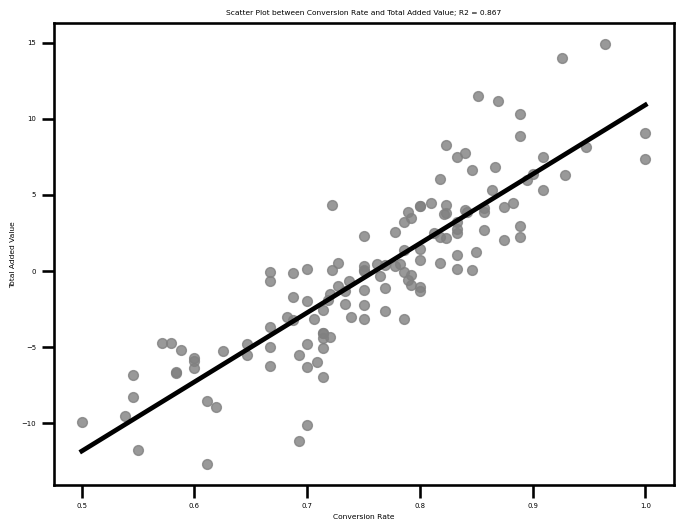

In [17]:
#Removing Total for scatter plot
kick_data['Conversion Rate'] = kick_data['FGM']/kick_data['FGA']
kick_data = kick_data.drop(kick_data.index[-1])

# Calculate the correlation coefficient (r value)
correlation = round(kick_data['Conversion Rate'].corr(kick_data['TOTAL_AV']),3)

plt.figure(figsize=(8, 6))
sns.regplot(x='Conversion Rate', y='TOTAL_AV', data=kick_data, scatter_kws={'s': 50, 'alpha': 0.8, 'color': 'gray'},ci=None, line_kws={'color': 'black'})
plt.title(f'Scatter Plot between Conversion Rate and Total Added Value; R2 = {correlation}')
plt.xlabel('Conversion Rate')
plt.ylabel('Total Added Value')
plt.show()

Did teams that went for it on 4th a lot cost kickers?

![Alt text](image.png)

In [18]:
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']